<a href="https://colab.research.google.com/github/WestChaeVI/Data-Network-Analysis/blob/main/week4_Pytorch_Dataset_Class_%EC%BB%A4%EC%8A%A4%ED%85%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pwd

'/content'

In [2]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [3]:
import torch
import torchvision
from torchvision import transforms #이미지 데이터 augmetation
import os
import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

In [4]:
train_path = '/content/drive/MyDrive/CV_seminar_project/train/'
test_path = '/content/drive/MyDrive/CV_seminar_project/test/'

dolphin_dir = 'dolphin'
shark_dir = 'shark'
whale_dir = 'whale'

# pytorch 테이터셋 클래스 실습

### 1. 라이브러리를 이용하기
이미지 전처리 하기
1. resize 하기 -> 224,224 (H,W)
2. tensor화 하기 -> 픽셀 값을 0~1로 바꾸기


In [5]:
preprop_imgs = transforms.Compose(
    [transforms.Resize( (224,224) ),
     transforms.ToTensor()]
)

preprop_train = torchvision.datasets.ImageFolder(root=train_path, transform= preprop_imgs)
preprop_test = torchvision.datasets.ImageFolder(root=test_path, transform= preprop_imgs)

In [6]:
preprop_train[0][0].shape # (C H W)

torch.Size([3, 224, 224])

Image Augmentation - 1

>Normalization
> (X - Mean)/Std -> 여러개가 이용 가능
>1. ImageNet 데이터세스이 Mean, std를 이용한다.
>2. 지금 내가 가지고 있는 데이터셋의 통계값을 이용한다.(train만)

In [7]:
Aug_imgs = transforms.Compose(
    [transforms.Resize( (224,224) ),
     transforms.RandomCrop(180), # 랜덤하게 짜르기
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue = 0.2), # 노이즈 추가
     transforms.RandomHorizontalFlip(p=0.5), # 이미지 좌우반전
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.299, 0.224, 0.225])
     ]

)

Aug_train = torchvision.datasets.ImageFolder(root=train_path, transform= Aug_imgs) #  augmentation 진행
Aug_test = torchvision.datasets.ImageFolder(root=test_path, transform= preprop_imgs) # test 셋은 augmentation 하지 않는다.

In [8]:
Aug_train[0][0].shape # (3, 180, 180)

torch.Size([3, 180, 180])

In [9]:
train_loader = torch.utils.data.DataLoader(Aug_train, batch_size= 4,
                                      shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(Aug_test, batch_size= 4,
                                      shuffle=True, num_workers=0)

In [11]:
for data, label in train_loader:
  break 

In [12]:
label # 이미지 라벨 ex(돌고래, 고래, 고래, 고래) -> one hot encoding 중요하다 하지만, 파이토치는 알아서 해줘서 굳이 x

tensor([2, 1, 0, 2])

In [13]:
data.shape # [4, 3, 224, 224] -> B,C,H,W

torch.Size([4, 3, 180, 180])

In [14]:
data[0]

tensor([[[-0.4679, -0.4417, -0.4417,  ..., -0.3367, -0.3367, -0.3367],
         [-0.4548, -0.4417, -0.4286,  ..., -0.3367, -0.3367, -0.3367],
         [-0.4548, -0.4286, -0.4286,  ..., -0.3367, -0.3367, -0.3367],
         ...,
         [-0.4286, -0.4286, -0.4286,  ..., -0.4023, -0.4023, -0.4286],
         [-0.4286, -0.4286, -0.4286,  ..., -0.4023, -0.4023, -0.4286],
         [-0.4417, -0.4417, -0.4417,  ..., -0.4023, -0.4023, -0.4286]],

        [[-1.9657, -1.9482, -1.9482,  ..., -1.9307, -1.9482, -1.9482],
         [-1.9482, -1.9482, -1.9307,  ..., -1.9307, -1.9482, -1.9482],
         [-1.9482, -1.9307, -1.9307,  ..., -1.9307, -1.9482, -1.9482],
         ...,
         [-1.9307, -1.9307, -1.9307,  ..., -1.9307, -1.9307, -1.9657],
         [-1.9307, -1.9307, -1.9307,  ..., -1.9307, -1.9307, -1.9657],
         [-1.9657, -1.9657, -1.9657,  ..., -1.9307, -1.9307, -1.9657]],

        [[ 0.7054,  0.7402,  0.7402,  ...,  0.8448,  0.8274,  0.8274],
         [ 0.7228,  0.7402,  0.7576,  ...,  0

### 파이토치 데이터셋 클래스 직접 만들기
1. __init__ 생성자가 필요함.
2. __getitem__ 필요함. -> 데이터를 읽는 역할 (인덱스를 부여, iterable)
3. __len__ 필요함. --> 데이터 개수를 알려주는 역할

In [21]:
from torch.utils.data import Dataset, DataLoader # 커스터마이징
import cv2
import os

class Custom_dataset(Dataset): #mode -> dataset 종류 (train, valid, test)
  def __init__(self, root_path, mode, transform=None): # 생성자 특수메소드
    self.all_data = sorted(glob.glob(os.path.join(root_path,mode,'*', '*'))) # 데이터 경로
    self.transform = transform # Augmentation

  def __getitem__(self, index):

    if torch.is_tensor(index): # 보험
      index = index.tolist()

    # 이미지 읽기
    data_path = self.all_data[index]
    image = cv2.imread(data_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR -> RGB 채널 축변환

    # transform(Augmentation)
    if self.transform is not None:
      augmentation = self.transform(image= image)
      image = augmentation['image']

    # label 부여
    if 'dolphin' in data_path.split('/')[-1]:
      label = 0
    elif  'shark' in data_path.split('/')[-1]:
      label = 1
    else:
      label = 2
    return image, label


  def __len__(self):
    length = len(self.all_data) # 전체 데이터 개수
    return length

In [22]:
root_path =  '/content/drive/MyDrive/CV_seminar_project/'
train_path = '/content/drive/MyDrive/CV_seminar_project/train/'
test_path = '/content/drive/MyDrive/CV_seminar_project/test/'

dolphin_dir = 'dolphin'
shark_dir = 'shark'
whale_dir = 'whale'

from PIL import Image as PILIamge

pytorch_dataset = Custom_dataset(root_path = root_path, mode ='train', transform = None)
# PILIamge.open(pytorch_dataset.all_data[0])

In [23]:
pytorch_dataset[0][1]

0

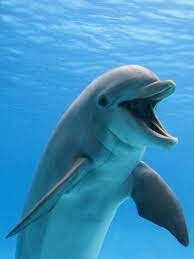

In [24]:
from google.colab.patches import cv2_imshow
import numpy as np
cv2_imshow(pytorch_dataset[0][0][:,:,::-1])

여기까지 해서 이미지가 잘 나왔으면 통과!

2. 더 강력한 augmentation 툴 albumentation 이용하기

In [34]:
import albumentations
import albumentations.pytorch

albumentations = albumentations.Compose( [
    albumentations.Resize(224,224),
    # 뒤집기, 돌리기
    albumentations.OneOf([
        albumentations.HorizontalFlip(p=0.8), # 좌우반전
        albumentations.VerticalFlip(p=0.8), # 상하반전
        albumentations.RandomRotate90(p=0.8), 
    ], p =1 ),

    # 픽셀값 장난질
    albumentations.OneOf([
        albumentations.MotionBlur(p=0.8),  # 흐리게
        albumentations.OpticalDistortion(p=0.8), # 왜곡
        albumentations.GaussNoise(p=0.8), # 노이즈 추가
    ], p =1 ),
    # albumentations.pytorch.transforms.ToTensorV2() # 0~1 만들기
])

pytorch_dataset = Custom_dataset(root_path = root_path, mode ='train', transform = albumentations)

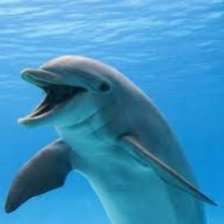

In [36]:
cv2_imshow(pytorch_dataset[0][0][:,:,::-1])